In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive/final_year_project_dataset')

In [ ]:
disease_types=['COVID', 'non-COVID']
data_dir = ''
train_dir = os.path.join(data_dir)

In [ ]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.head()

,File,DiseaseID,Disease Type
0,COVID/Covid (1225).png,0,COVID
1,COVID/Covid (1226).png,0,COVID
2,COVID/Covid (1227).png,0,COVID
3,COVID/Covid (1228).png,0,COVID
4,COVID/Covid (1229).png,0,COVID


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2481 entries, 0 to 2480
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   File          2481 non-null   object
 1   DiseaseID     2481 non-null   int64 
 2   Disease Type  2481 non-null   object
dtypes: int64(1), object(2)
memory usage: 58.3+ KB


In [ ]:
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()  

,File,DiseaseID,Disease Type
0,COVID/Covid (327).png,0,COVID
1,COVID/Covid (658).png,0,COVID
2,non-COVID/Non-Covid (529).png,1,non-COVID
3,non-COVID/Non-Covid (585).png,1,non-COVID
4,COVID/Covid (836).png,0,COVID


In [ ]:
IMAGE_SIZE = 64
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [ ]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

2481it [00:20, 123.57it/s]


Train Shape: (2481, 64, 64, 3)


In [ ]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=2)
print(Y_train.shape)

(2481, 2)


In [ ]:
model = load_model("model.h5")

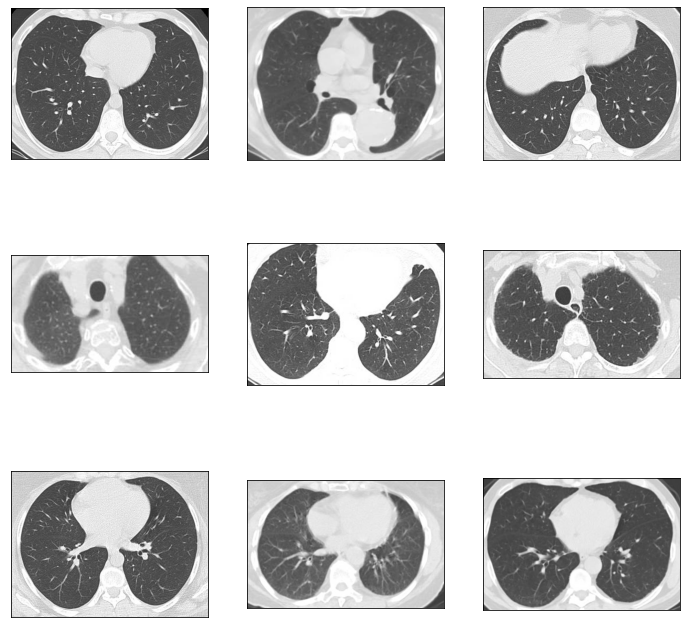

In [ ]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            
            n += 1
# Displays first n images of class from training set
plot_defects('non-COVID', 3, 3)

In [ ]:
import numpy as np
import keras
from keras.applications.imagenet_utils import decode_predictions
import skimage.io 
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import warnings

Top prediction class

In [ ]:
preds = model.predict(X_Train[4][np.newaxis,:,:,:])
preds

array([[0.99443996, 0.00556012]], dtype=float32)

Calculate number of super pixels

> https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.quickshift



In [ ]:
superpixels = skimage.segmentation.quickshift(X_Train[4], kernel_size=2,max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
num_superpixels

14

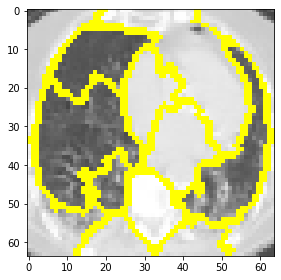

In [ ]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(X_Train[4], superpixels))

In [ ]:
num_perturb = 200
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
perturbations[0] #Show example of perturbation

array([1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0])

The following function perturb_image perturbs the given image (img) based on a perturbation vector (perturbation) and predefined superpixels (segments).

In [ ]:
def perturb_image(img,perturbation,segments):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image

Let's use the previous function to see what a perturbed image would look like:

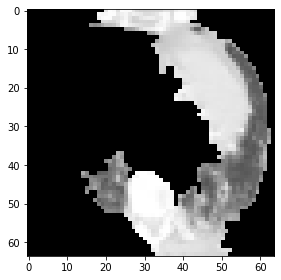

In [ ]:
skimage.io.imshow(perturb_image(X_Train[4],perturbations[7],superpixels))

This is the most computationally expensive step in LIME because a prediction for each perturbed image is computed. From the shape of the predictions we can see for each of the perturbations we have the output probability for each of the 1000 classes in Inception V3. 

In [ ]:
predictions = []
for pert in perturbations:
  perturbed_img = perturb_image(X_Train[4],pert,superpixels)
  pred = model.predict(perturbed_img[np.newaxis,:,:,:])
  predictions.append(pred)

predictions = np.array(predictions)
predictions.shape

(200, 1, 2)

In [ ]:
predictions

array([[[0.8019837 , 0.19801626]],

       [[0.660946  , 0.33905396]],

       [[0.63972586, 0.36027417]],

       [[0.18359224, 0.8164077 ]],

       [[0.8877451 , 0.11225489]],

       [[0.8476405 , 0.15235947]],

       [[0.3948365 , 0.6051635 ]],

       [[0.82152915, 0.17847084]],

       [[0.8355456 , 0.16445437]],

       [[0.724977  , 0.27502298]],

       [[0.90504783, 0.0949521 ]],

       [[0.69170684, 0.30829316]],

       [[0.565422  , 0.434578  ]],

       [[0.8368753 , 0.16312468]],

       [[0.25091925, 0.7490808 ]],

       [[0.8269262 , 0.17307378]],

       [[0.9297994 , 0.0702006 ]],

       [[0.81789917, 0.18210085]],

       [[0.92044073, 0.07955926]],

       [[0.8432543 , 0.15674566]],

       [[0.6032367 , 0.39676332]],

       [[0.64314854, 0.35685143]],

       [[0.7227825 , 0.27721748]],

       [[0.31380793, 0.68619204]],

       [[0.9067271 , 0.09327298]],

       [[0.7375347 , 0.26246533]],

       [[0.65458757, 0.3454124 ]],

       [[0.6073042 , 0.39269


The distance between each randomly generated perturnation and the image being explained is computed using the cosine distance. For the shape of the `distances` array it can be noted that, as expected, there is a distance for every generated perturbation.

In [ ]:
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
distances.shape

(200,)



```
# This is formatted as code
```

Use kernel function to compute weights
The distances are then mapped to a value between zero and one (weight) using a kernel function. An example of a kernel function with different kernel widths is shown in the plot below. Here the x axis represents distances and the y axis the weights. Depeding on how we set the kernel width, it defines how wide we want the "locality" around our instance to be. This kernel width can be set based on expected distance values. For the case of cosine distances, we expect them to be somehow stable (between 0 and 1); therefore, no fine tunning of the kernel width might be required.

<img src="https://arteagac.github.io/blog/lime_image/img/kernel.png" alt="Drawing" width="600"/>

In [ ]:
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
weights.shape

(200,)

 Use `perturbations`, `predictions` and `weights` to fit an explainable (linear) model
A weighed linear regression model is fitted using data from the previous steps (perturbations, predictions and weights). Given that the class that we want to explain is labrador, when fitting the linear model we take from the predictions vector only the column corresponding to the top predicted class. Each coefficients in the linear model corresponds to one superpixel in the segmented image. These coefficients represent how important is each superpixel for the prediction of labrador.

In [ ]:
class_to_explain = 0# has higher probability
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]
coeff 

array([ 0.01333761, -0.00662959, -0.10075501,  0.08680197, -0.07627982,
       -0.02440586, -0.08264273,  0.00296708, -0.0415032 ,  0.01624707,
       -0.00542331,  0.0181042 ,  0.09865576, -0.06590178])

Compute top features (superpixels)
Now we just need to sort the coefficients to figure out which are the supperpixels that have larger coefficients (magnitude) for the prediction of labradors. The identifiers of these top features or superpixels are shown below. Even though here we use the magnitude of the coefficients to determine the most important features, other alternatives such as forward or backward elimination can be used for feature importance selection. 

In [ ]:
num_top_features = 2
top_features = np.argsort(coeff)[-num_top_features:] 
top_features

array([ 3, 12])

Show LIME explanation (image with top features)
Let's show the most important superpixels defined in the previous step in an image after covering up less relevant superpixels.

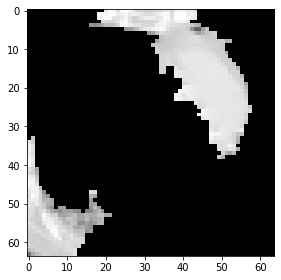

In [ ]:
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(X_Train[4],mask,superpixels) )

In [ ]:
def ExplainableAI(image):
  IMAGE_SIZE = 64
  image= cv2.resize(image.copy(), (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)
  image=image/255
  model = load_model("model.h5")
  preds = model.predict(image[np.newaxis,:,:,:])
  superpixels = skimage.segmentation.quickshift(image, kernel_size=2,max_dist=200, ratio=0.2)
  num_superpixels = np.unique(superpixels).shape[0]
  num_perturb = 200
  perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
  def perturb_image(img,perturbation,segments):
    active_pixels = np.where(perturbation == 1)[0]
    mask = np.zeros(segments.shape)
    for active in active_pixels:
        mask[segments == active] = 1 
    perturbed_image = copy.deepcopy(img)
    perturbed_image = perturbed_image*mask[:,:,np.newaxis]
    return perturbed_image
  predictions = []
  for pert in perturbations:
    perturbed_img = perturb_image(image,pert,superpixels)
    pred = model.predict(perturbed_img[np.newaxis,:,:,:])
    predictions.append(pred)
  predictions = np.array(predictions)
  original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
  distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
  kernel_width = 0.25
  weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
  class_to_explain = 0# has higher probability  
  if preds[0][1]>preds[0][0]:
    class_to_explain=1
  simpler_model = LinearRegression()
  simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
  coeff = simpler_model.coef_[0]
  num_top_features = 3
  top_features = np.argsort(coeff)[-num_top_features:] 
  mask = np.zeros(num_superpixels) 
  mask[top_features]= True #Activate top superpixels
  skimage.io.imshow(perturb_image(image,mask,superpixels) )
  return perturb_image(image,mask,superpixels)

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

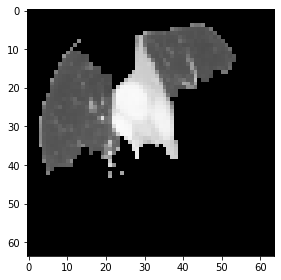

In [ ]:
ExplainableAI(cv2.imread(os.path.join(data_dir, train['File'][2])))